### Name : Amruta Mulay , Github Username : Amruta131198 , USC ID : 6897885438

In [1]:
#Importing all necessary libraries required for HW-2

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
import math
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import normalize
import random
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import euclidean_distances

## Combined Cycle Power Plant Data Set

### (a) Download the Combined Cycle Power Plant data

In [2]:
data = "../data/Folds5x2_pp.xlsx"
ccpp = pd.read_excel(data)

### (b) Exploring the data :

#### (b-i). How many rows are in this data set? How many columns? What do the rows and columns represent?

In [3]:
ccpp

,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90
...,...,...,...,...,...
9563,16.65,49.69,1014.01,91.00,460.03
9564,13.19,39.18,1023.67,66.78,469.62
9565,31.32,74.33,1012.92,36.48,429.57
9566,24.48,69.45,1013.86,62.39,435.74


##### As we can observe in the table above that there are 9568 rows and 5 columns. Each of the given rows is representing a sample datapoint associated different features. The columns describe what the four main features, which consist of hourly average ambient variables Temperature (AT), Ambient Pressure (AP), Relative Humidity (RH) and Exhaust Vacuum (V) to predict the net hourly electrical energy output (PE)  of the plant. 

#### (b-ii). Make pairwise scatterplots of all the variables in the data set including the predictors (independent variables) with the dependent variable. Describe your findings.

Text(0.5, 1.01, 'Scatter Plot of all Features of Dataset')

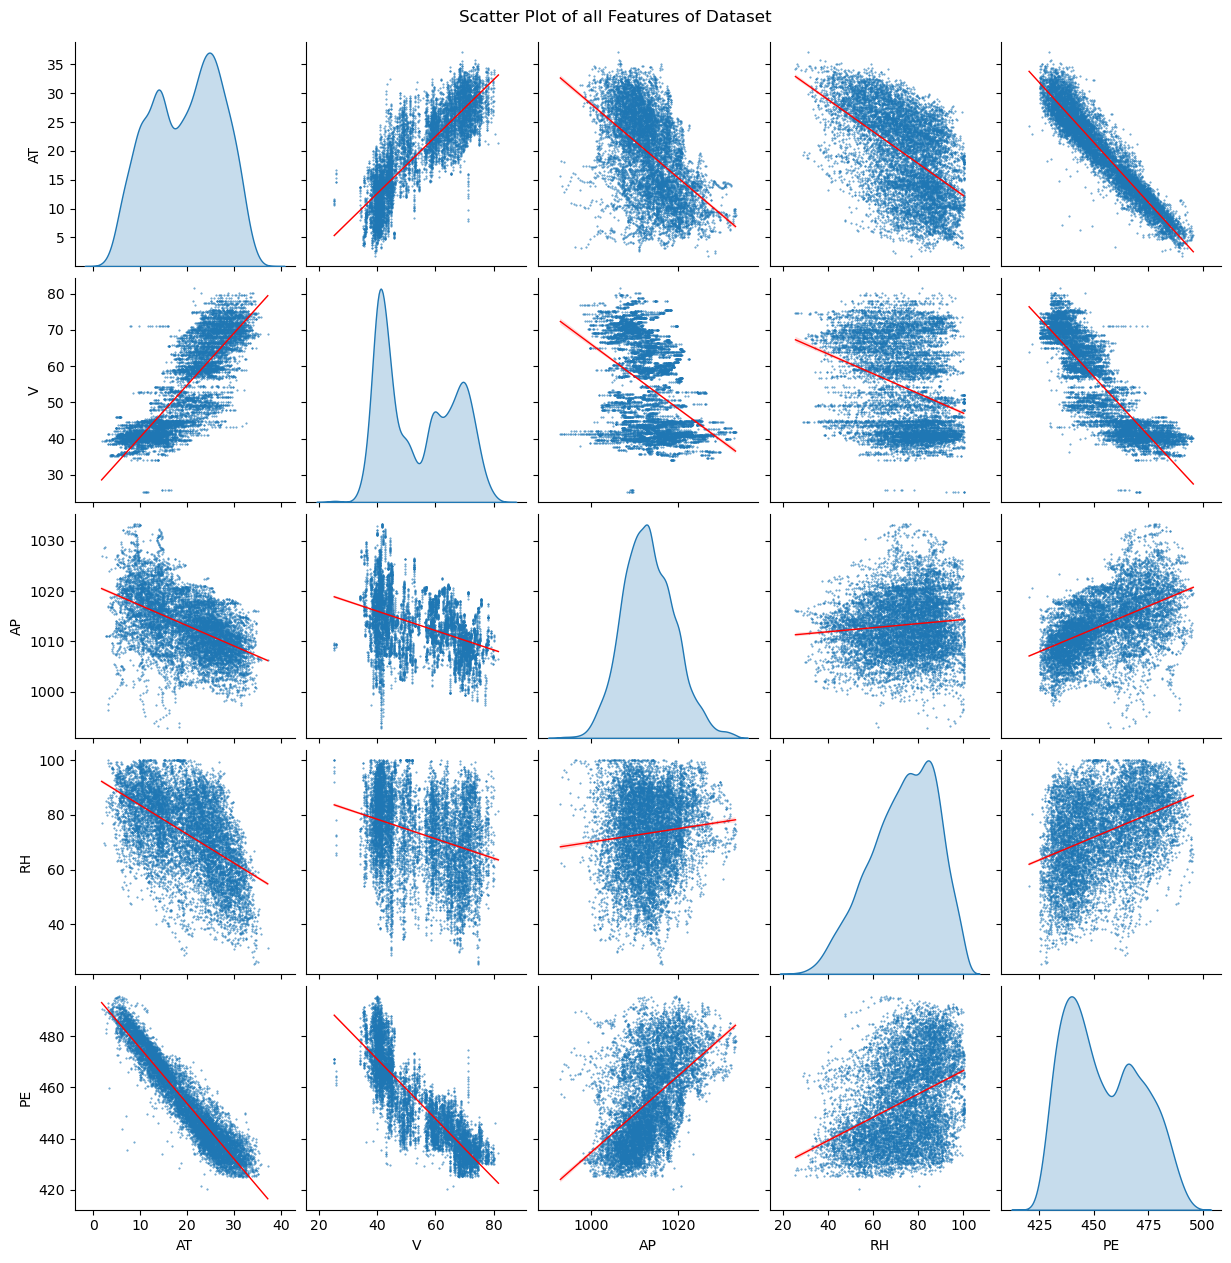

In [4]:
# initializing and defining scatterplot
scatter_plot = sns.pairplot(ccpp, diag_kind="kde", kind="reg", 
                            plot_kws={'line_kws':{'color':'red', "linewidth": 1}, 'scatter_kws': {'s': 0.2}})
scatter_plot.fig.suptitle("Scatter Plot of all Features of Dataset", y=1.01)

##### Correlation of the dataset observed from the Scatter Plot - 
Based on the scatter plot generated, we can observe that the datapoints are very densely populated and clustered closely to the red regression line specifically for AT and V. Therefore, we can conclude that :
- AT is negatively correlated with PE
- V is negatively correlated with PE

#### (b-iii).What are the mean, the median, range, first and third quartiles, and interquartile ranges of each of the variables in the dataset? Summarize them in a table.

In [5]:
feature = [col for col in ccpp.columns]
mean = [np.around(ccpp[col].mean(), 2) for col in ccpp.columns]
median = [np.around(ccpp[col].median(), 2) for col in ccpp.columns]
_range = [np.around(ccpp[col].max() - ccpp[col].min(), 2) for col in ccpp.columns]
firstQ = [np.around(ccpp[col].quantile(0.25), 2) for col in ccpp.columns]
thirdQ = [np.around(ccpp[col].quantile(0.75), 2) for col in ccpp.columns]
IQR = [np.around(y - x, 2) for x, y in zip(firstQ, thirdQ)]

data_summary = {
    "Feature" : feature,
    "Mean/Average" : mean,
    "Median" : median,
    "Range" : _range,
    "1st Quartile" : firstQ,
    "3rd Quartile" : thirdQ,
    "Inter-Quartile Range" : IQR
}

data_summary = pd.DataFrame(data_summary)
data_summary.set_index("Feature")
data_summary

,Feature,Mean/Average,Median,Range,1st Quartile,3rd Quartile,Inter-Quartile Range
0,AT,19.65,20.34,35.30,13.51,25.72,12.21
1,V,54.31,52.08,56.20,41.74,66.54,24.80
2,AP,1013.26,1012.94,40.41,1009.10,1017.26,8.16
3,RH,73.31,74.97,74.60,63.33,84.83,21.50
4,PE,454.37,451.55,75.50,439.75,468.43,28.68


### (c) For each predictor, fit a simple linear regression model to predict the response. Describe your results. In which of the models is there a statistically significant association between the predictor and the response? Create some plots to back up your assertions. Are there any outliers that you would like to remove from your data for each of these regression tasks?

In [6]:
# splitting featues and output variables into separate numpy arrays
trainX_AT = ccpp['AT'].to_numpy()
trainX_V = ccpp['V'].to_numpy()
trainX_AP = ccpp['AP'].to_numpy()
trainX_RH = ccpp['RH'].to_numpy()
trainY_PE = ccpp['PE'].to_numpy()

P_THRESH = 0.05
THRESHOLD = 4 / len(ccpp) #Cook's Distance Threshold for determining highly influential points as outliers 
model_coefficients = {}

# Perform linear regression for each predictor
def linear_regression_model_fitting_and_summary(trainX_independent_features, trainY_dependent, feature_name):
    # Note this adds a column of constants to the X dataframe to enable bias, before passing it into OLS() function
    trainX = sm.add_constant(trainX_independent_features, prepend=False)
    ols_model = sm.OLS(trainY_dependent, trainX)
    ols_result = ols_model.fit()
    
    # Record the coefficients for this Linear Regression Model and Summarize ...
    model_coefficients[feature_name] = ols_result.params #Beta0 and Beta1
#     print(f"Model Coefficients : {ols_result.params}")
    print(ols_result.summary())
    
    # OUTLIER DETECTION - https://gist.github.com/rnelsonchem/6693120
#     outliers = ols_result.outlier_test()
#     print(f"Outliers : {outliers[:, 2]}")
#     outliers_idx = np.where(outliers[:, 2] < P_THRESH)
    
    # OUTLIER DETECTION - Using Cook's Distance
    influence = ols_result.get_influence()
    cooks = influence.cooks_distance
    outliers_idx = np.where(cooks[0] > THRESHOLD)
    
    # plot regression graph with outliers marked
    fig, axes = plt.subplots(figsize=(12, 7))
    with plt.style.context('ggplot'):
        axes.scatter(trainX_independent_features, trainY_dependent, alpha=0.3, label="Data point")
        axes.scatter(trainX_independent_features[outliers_idx], trainY_dependent[outliers_idx], marker="+", label="Outliers")
        axes.plot(trainX_independent_features, ols_result.predict(trainX), "tab:red", alpha=0.8, label="Rgression Result")
    axes.set_title("Simple Linear Regression for Feature : {}".format(feature_name))
    axes.set_xlabel(feature_name)
    axes.set_ylabel("PE")
    axes.legend()
    plt.show()
    
    # output outliers as table
    outliers_tuple = np.vstack((trainX_independent_features[outliers_idx], trainY_dependent[outliers_idx]))
    return pd.DataFrame(outliers_tuple.T, columns=[feature_name, "PE"])

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                 8.510e+04
Date:                Thu, 21 Sep 2023   Prob (F-statistic):               0.00
Time:                        11:54:13   Log-Likelihood:                -29756.
No. Observations:                9568   AIC:                         5.952e+04
Df Residuals:                    9566   BIC:                         5.953e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -2.1713      0.007   -291.715      0.0

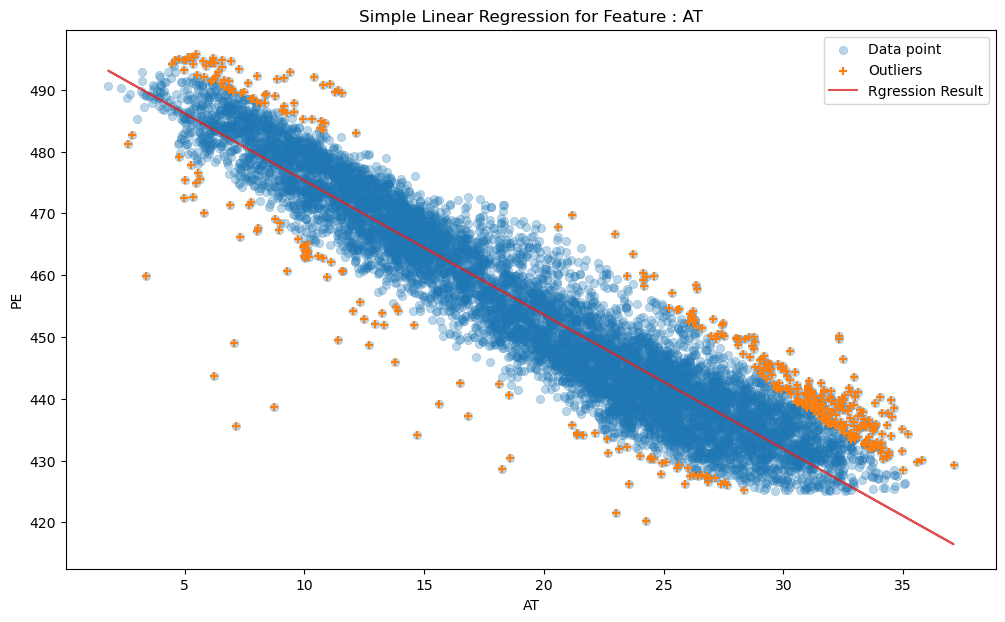

,AT,PE
0,5.41,495.24
1,29.01,446.22
2,32.72,437.99
3,35.56,429.69
4,27.54,450.22
...,...,...
411,33.20,438.12
412,30.26,442.98
413,34.03,440.29
414,5.01,475.34


In [7]:
# Passing each Predictor into Linear Regression Model
outlier_AT = linear_regression_model_fitting_and_summary(trainX_AT, trainY_PE, "AT")
outlier_AT

######  416 outliers detected for Predictor AT and Response PE

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.757
Model:                            OLS   Adj. R-squared:                  0.756
Method:                 Least Squares   F-statistic:                 2.972e+04
Date:                Thu, 21 Sep 2023   Prob (F-statistic):               0.00
Time:                        11:54:13   Log-Likelihood:                -33963.
No. Observations:                9568   AIC:                         6.793e+04
Df Residuals:                    9566   BIC:                         6.794e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -1.1681      0.007   -172.402      0.0

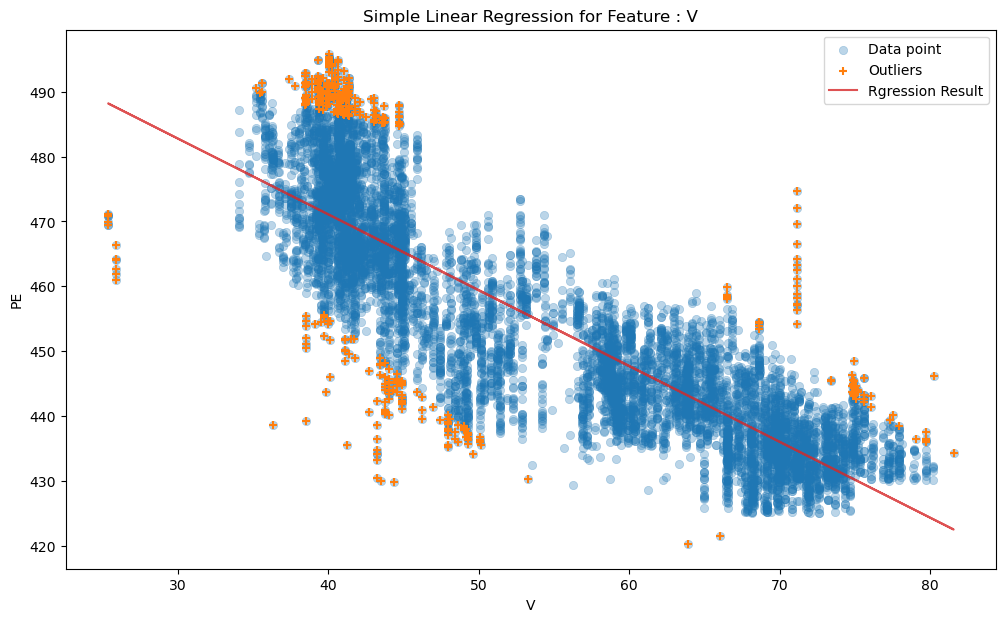

,V,PE
0,39.40,488.56
1,40.07,495.24
2,48.60,436.06
3,43.43,448.06
4,39.33,491.49
...,...,...
418,75.23,443.78
419,39.72,455.58
420,44.89,445.45
421,43.77,446.05


In [8]:
# Passing each Predictor into Linear Regression Model
outlier_V = linear_regression_model_fitting_and_summary(trainX_V, trainY_PE, "V")
outlier_V

######  423 outlier detected for Predictor V and Response PE

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.269
Model:                            OLS   Adj. R-squared:                  0.269
Method:                 Least Squares   F-statistic:                     3516.
Date:                Thu, 21 Sep 2023   Prob (F-statistic):               0.00
Time:                        11:54:13   Log-Likelihood:                -39224.
No. Observations:                9568   AIC:                         7.845e+04
Df Residuals:                    9566   BIC:                         7.847e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.4899      0.025     59.296      0.0

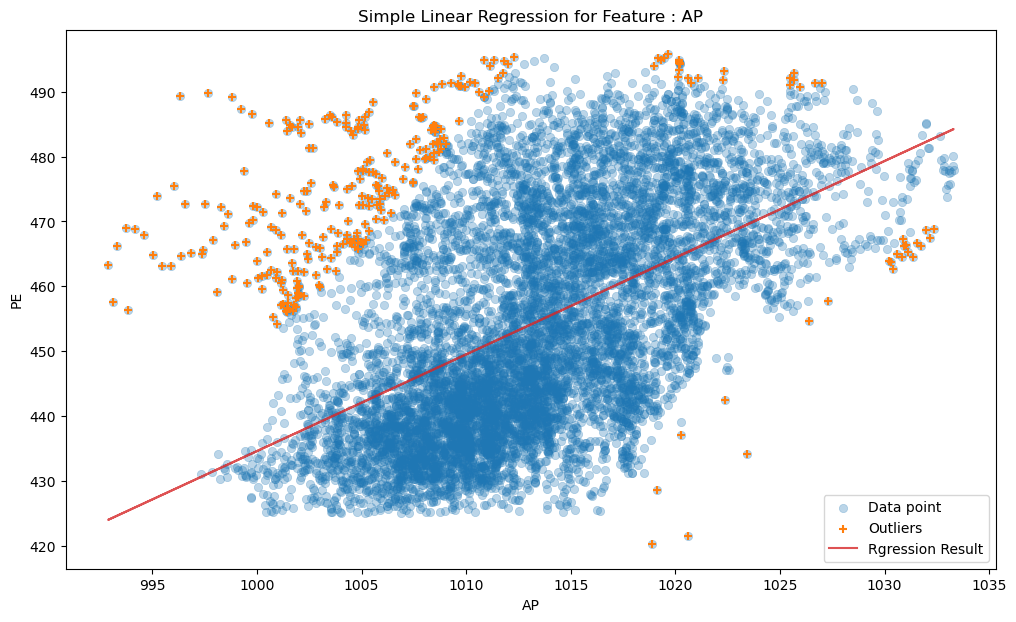

,AP,PE
0,1019.16,495.24
1,1008.52,483.80
2,1010.18,491.49
3,1008.82,481.09
4,1001.24,459.36
...,...,...
295,1030.61,464.95
296,1008.43,484.75
297,1005.24,479.22
298,998.27,472.16


In [9]:
# Passing each Predictor into Linear Regression Model
outlier_AP = linear_regression_model_fitting_and_summary(trainX_AP, trainY_PE, "AP")
outlier_AP

######  300 outliers detected for Predictor AP and Response PE!

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.152
Model:                            OLS   Adj. R-squared:                  0.152
Method:                 Least Squares   F-statistic:                     1714.
Date:                Thu, 21 Sep 2023   Prob (F-statistic):               0.00
Time:                        11:54:14   Log-Likelihood:                -39933.
No. Observations:                9568   AIC:                         7.987e+04
Df Residuals:                    9566   BIC:                         7.988e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.4557      0.011     41.399      0.0

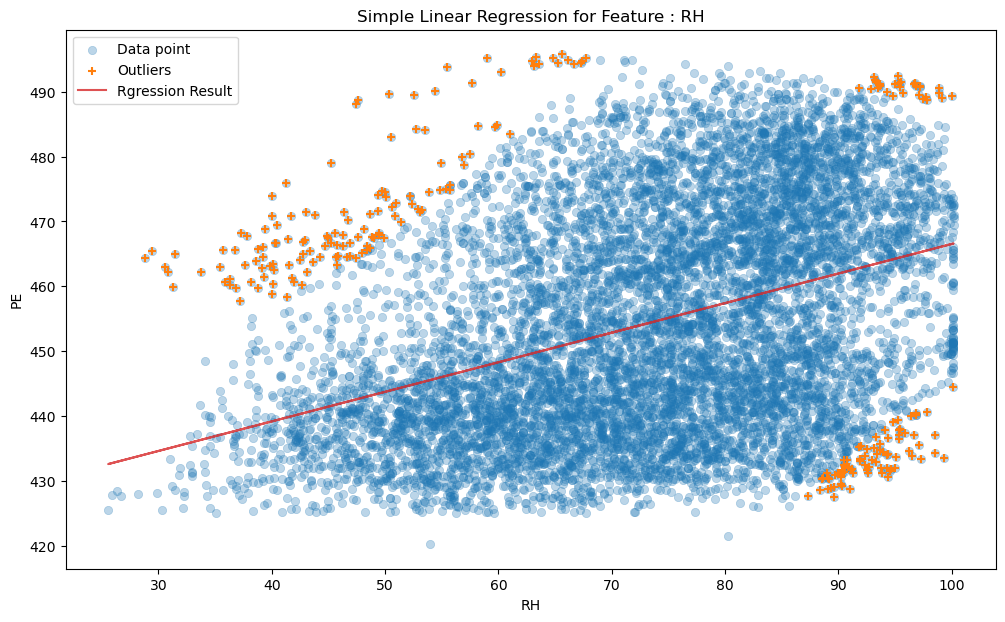

,RH,PE
0,41.25,475.98
1,43.08,462.19
2,48.84,467.54
3,64.77,495.24
4,50.00,474.60
...,...,...
244,97.21,490.68
245,98.84,490.50
246,90.20,430.55
247,93.39,434.11


In [10]:
outliers_RH = linear_regression_model_fitting_and_summary(trainX_RH, trainY_PE, "RH")
outliers_RH

######  249 outliers detected for Predictor RH and Response PE!

### d) Fit a multiple regression model to predict the response using all of the predictors. Describe your results. For which predictors can we reject the null hypothesis H0 : βj = 0?

In [11]:
trainingX_all = ccpp.iloc[:, 0:len(ccpp.columns) - 1]
trainingX_all = sm.add_constant(trainingX_all.to_numpy(), prepend=False)

model_multiple_regression = sm.OLS(ccpp["PE"].to_numpy(), trainingX_all)
model_multiple_regression = model_multiple_regression.fit()

print(model_multiple_regression.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                 3.114e+04
Date:                Thu, 21 Sep 2023   Prob (F-statistic):               0.00
Time:                        11:54:14   Log-Likelihood:                -28088.
No. Observations:                9568   AIC:                         5.619e+04
Df Residuals:                    9563   BIC:                         5.622e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -1.9775      0.015   -129.342      0.0

##### The null hypothesis can be rejected for all the predictors since the p-value is 0 for all of them !!

### (e) How do your results from 1c compare to your results from 1d? Create a plot displaying the univariate regression coefficients from 1c on the x-axis, and the multiple regression coefficients from 1d on the y-axis. That is, each predictor is displayed as a single point in the plot. Its coefficient in a simple linear regression model is shown on the x-axis, and its coefficient estimate in the multiple linear regression model is shown on the y-axis.

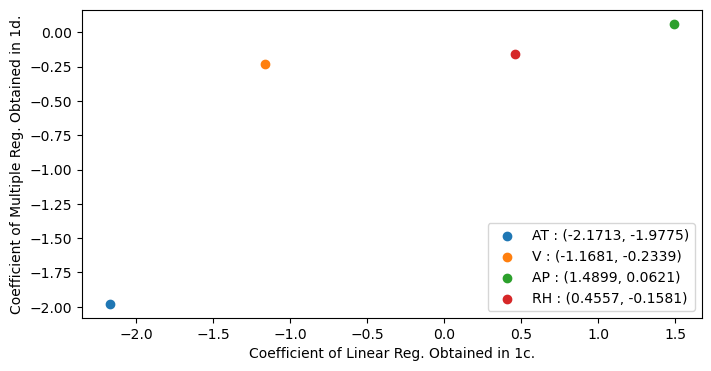

In [12]:
fig, axes = plt.subplots(figsize=(8, 4))
for i, feature in enumerate(ccpp.columns[:-1]):
    text = "{} : ({}, {})".format(feature, 
                                        np.around(model_coefficients[feature][0], 4), 
                                        np.around(model_multiple_regression.params[i], 4))
    axes.scatter(model_coefficients[feature][0], model_multiple_regression.params[i], label=text)
axes.legend()
axes.set_xlabel("Coefficient of Linear Reg. Obtained in 1c.")
axes.set_ylabel("Coefficient of Multiple Reg. Obtained in 1d.")
plt.show()

### (f) Is there evidence of nonlinear association between any of the predictors and the response?

In [13]:
POLYNOMIAL_DEGREE = 3

def check_non_linearity_trait(feature_name):
    polynomial_reg = PolynomialFeatures(POLYNOMIAL_DEGREE)
    trainingX_polynomial = polynomial_reg.fit_transform(ccpp[feature_name].to_numpy().reshape(-1, 1))
    poly_model = sm.OLS(ccpp["PE"].to_numpy(), trainingX_polynomial).fit()
    print(poly_model.summary())

In [14]:
print("\n\nChecking Non-Linearity Accosiation for feature: AT")
check_non_linearity_trait("AT")

print("\n\nChecking Non-Linearity Accosiation for feature: V")
check_non_linearity_trait("V")

print("\n\nChecking Non-Linearity Accosiation for feature: AP")
check_non_linearity_trait("AP")

print("\n\nChecking Non-Linearity Accosiation for feature: RH")
check_non_linearity_trait("RH")



Checking Non-Linearity Accosiation for feature: AT
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.912
Model:                            OLS   Adj. R-squared:                  0.912
Method:                 Least Squares   F-statistic:                 3.299e+04
Date:                Thu, 21 Sep 2023   Prob (F-statistic):               0.00
Time:                        11:54:15   Log-Likelihood:                -29101.
No. Observations:                9568   AIC:                         5.821e+04
Df Residuals:                    9564   BIC:                         5.824e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------

#### Observations from the Summary shown above :

- Considering features AT, AP and RH, the p-value associated with it is equal to zero (which is less than 0.05) and hence, we can reject the null hypothesis (H0) signifying that there is evidence of non-linear association between these predictors and response PE.

- However, for predictor V, the p-value for $x^2$ and $x^3$ is not negligible and for $x^2$ especially, it is of significant number (greater than 0.05). Therfore, we cannot reject the null hypothesis (H0) and hence we can conclude that there is no non-linear association between the predictor V and the response PE.

### (g) Is there evidence of association of interactions of predictors with the response? To answer this question, run a full linear regression model with all pairwise interaction terms and state whether any interaction terms are statistically significant.

In [15]:
predictors_interaction = 'PE ~ AT + V + AP + RH + AT*V + AT*AP + AT*RH + V*AP + V*RH + AP*RH'
regression_model_with_interactions = smf.ols(formula = predictors_interaction, data = ccpp).fit()
print(regression_model_with_interactions.summary())

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.936
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                 1.405e+04
Date:                Thu, 21 Sep 2023   Prob (F-statistic):               0.00
Time:                        11:54:15   Log-Likelihood:                -27548.
No. Observations:                9568   AIC:                         5.512e+04
Df Residuals:                    9557   BIC:                         5.520e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    685.7825     78.640      8.721      0.0

#### Observations:

> Smaller the p-value, greater is the 'Statistical Significance' of the predictor. Given different p-values associated with the output, the summarization of the results are as follows - 
- When threshold p = 0.05, $V, AP, RH, AT:V, AT:RH, V:AP, AP:RH$ are statistically significant
- When threshold p = 0.10, $AT, V:RH$ are also statistically significant
- AT:AP have very large p-value (i.e. 0.452 >> 0.1) and are not statistically significant

### (h) Can you improve your model using possible interaction terms or nonlinear associations between the predictors and response? Train the regression model on a randomly selected 70% subset of the data with all predictors. Also, run a regression model involving all possible interaction terms and quadratic nonlinearities, and remove insignificant variables using p-values (be careful about interaction terms). Test both models on the remaining points and report your train and test MSEs.

In [16]:
# Shuffle data by generating random indices since fitting differs when dealing with different training sets.
# Random Seed will select data randomly from original dataset & keep it fixed for reference in different experiments
ids = [i for i in range(0,len(ccpp))]
random.seed(len(ccpp))
random.shuffle(ids)

# Split Dataset into Train - 70% & Test - 30%
train_size = round(len(ccpp) * 0.7)
train_data_70 = ccpp.iloc[ids[:train_size], :]
train_X_70 = train_data_70.iloc[:, :-1]
train_Y_70 = train_data_70.iloc[:, -1:]
test_X_30 = ccpp.iloc[ids[train_size:], :-1]
test_Y_30 = ccpp.iloc[ids[train_size:], -1:]

# Store the summary of all the regression models that we will be assessing
summaraize_model_mse = {}
# Dictionary to keep track of MSE for different models
mse_dict = {}

print(ccpp.shape)
print(train_size)
print(train_data_70.shape)
print(train_X_70.shape)
print(train_Y_70.shape)
print(test_X_30.shape)
print(test_Y_30.shape)

(9568, 5)
6698
(6698, 5)
(6698, 4)
(6698, 1)
(2870, 4)
(2870, 1)


In [17]:
def Regression_Model(model_type, formula):
    model = smf.ols(formula, train_data_70).fit()
    print(model.summary())
    
    predict_trainY = model.predict(train_X_70)
    predict_testY = model.predict(test_X_30)
    
    train_mse = mean_squared_error(train_Y_70, predict_trainY)
    test_mse = mean_squared_error(test_Y_30, predict_testY)
    
    brief_MSE = {"Formula": formula, "Train MSE": round(train_mse, 4), "Test MSE": round(test_mse, 4)}
    summaraize_model_mse[model_type] = [train_mse, test_mse]
    
    return pd.DataFrame(data=brief_MSE.items(), columns=['KEY', 'VALUE'])

In [18]:
linear_reg_formula = "PE ~ AT + V + AP + RH"
Regression_Model("all_predictors_linear_reg", linear_reg_formula)

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.928
Model:                            OLS   Adj. R-squared:                  0.928
Method:                 Least Squares   F-statistic:                 2.168e+04
Date:                Thu, 21 Sep 2023   Prob (F-statistic):               0.00
Time:                        11:54:15   Log-Likelihood:                -19623.
No. Observations:                6698   AIC:                         3.926e+04
Df Residuals:                    6693   BIC:                         3.929e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    446.0206     11.661     38.250      0.0

,KEY,VALUE
0,Formula,PE ~ AT + V + AP + RH
1,Train MSE,20.5187
2,Test MSE,21.3571


In [19]:
quadratic_terms_formula = 'PE ~ AT + V + AP + RH + np.power(AT,2) + np.power(V,2) + np.power(AP,2) + np.power(RH,2) + AT*V + AT*AP + AT*RH + V*AP + V*RH + AP*RH'
Regression_Model("quadratic_terms_linear_reg", quadratic_terms_formula)

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.938
Model:                            OLS   Adj. R-squared:                  0.937
Method:                 Least Squares   F-statistic:                     7173.
Date:                Thu, 21 Sep 2023   Prob (F-statistic):               0.00
Time:                        11:54:15   Log-Likelihood:                -19160.
No. Observations:                6698   AIC:                         3.835e+04
Df Residuals:                    6683   BIC:                         3.845e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept       -6396.5247   1454.668     

,KEY,VALUE
0,Formula,"PE ~ AT + V + AP + RH + np.power(AT,2) + np.po..."
1,Train MSE,17.8713
2,Test MSE,18.6776


> Analysing the above results, we cannot reject the Null Hypothesis (H0) of $AT$, $V$, $V^2$, $AT:AP$, $V:AP$ and $V:RH$. Thus, we will only remove the 2-order terms. Although $AT$ and $V$ have large p-value as well, removing basic predictors will violate the hierachical priciple when the $AT:V$, $AT:AP$, $V:AP$, $V:RH$ is included. Therefore, we keep the main effect even when they are statistically insignificant since the interactions are hard to interpret in a model without the main effect as their meaning is changed!

> **NOTE** We are shuffling the data before splitting into training set & test set, therefore, the result may be different when the script is executed again if the random seed is not fixed. It has been observed that $AT$ may show up p-value > 0.05 and sometimes not.

In [20]:
#From the above analysis, removing V^2, V:AP, V:RH, AT:AP
discard_insignificant_predictors_formula = 'PE ~ AT + V + AP + RH + np.power(AT,2) + np.power(AP,2) + np.power(RH,2) + AT*V + AT*RH + AP*RH'
Regression_Model("discard_insignificant_predictors_linear_reg", discard_insignificant_predictors_formula)

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.937
Model:                            OLS   Adj. R-squared:                  0.937
Method:                 Least Squares   F-statistic:                 1.001e+04
Date:                Thu, 21 Sep 2023   Prob (F-statistic):               0.00
Time:                        11:54:15   Log-Likelihood:                -19170.
No. Observations:                6698   AIC:                         3.836e+04
Df Residuals:                    6687   BIC:                         3.844e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept       -1.025e+04   1096.773     

,KEY,VALUE
0,Formula,"PE ~ AT + V + AP + RH + np.power(AT,2) + np.po..."
1,Train MSE,17.9264
2,Test MSE,18.6596


> Analysing all the models i.e linear, quadratic and the one with nonlinear terms, we observe a significant improvement in the Test set MSE from 21.3571 to 18.6596

### (i). KNN Regression:
##### Perform $k$-nearest neighbor regression for this dataset using both normalized and raw features. Find the value of $k \in {1,2,..., 100}$ that gives you the best fit. Plot the train and test errors in terms of $1/k$

In [21]:
def KNN_Regression(mode_type):
    min_index = 0
    train_error = []
    test_error = []
    reciprocal_k = []
    
    if mode_type == "NORMALIZED_KNN":
        print("NORMALIZED Mode Type Activated")
        scaler = MinMaxScaler()
        train_X_70_knn = scaler.fit_transform(train_X_70)
        test_X_30_knn = scaler.fit_transform(test_X_30)
    else:
        print("RAW Mode Type Activated")
        train_X_70_knn = train_X_70
        test_X_30_knn = test_X_30
        
    for k in range(1, 101):
        knn = KNeighborsRegressor(n_neighbors=k)
        knn.fit(train_X_70_knn, train_Y_70)
        reciprocal_k.append(1 / k)
        train_predict = knn.predict(train_X_70_knn)
        test_predict = knn.predict(test_X_30_knn)
        train_mse = mean_squared_error(train_Y_70, train_predict)
        test_mse = mean_squared_error(test_Y_30, test_predict)
        train_error.append(train_mse)
        test_error.append(test_mse)
        if test_mse < test_error[min_index]:
            min_index = k - 1;
            
    summaraize_model_mse[mode_type] = [train_error[min_index], test_error[min_index]]
    brief = {
        "Mode Type": mode_type,
        "Train Error": round(train_error[min_index], 4),
        "Test Error": round(test_error[min_index], 4),
        "Reciprocal of k": reciprocal_k,
        "k": round((1 / reciprocal_k[min_index]), 4)
    }
    
    specs = {
        "Reciprocal of k": reciprocal_k,
        "Train Error": train_error,
        "Test Error": test_error,
        "Error Summary": summaraize_model_mse
    }
    
    return [brief, specs]

def plot_graph(reciprocal_k, train_error, test_error):
    plt.plot(reciprocal_k, train_error, label="Training MSE")
    plt.plot(reciprocal_k, test_error, label="Testing MSE")
    plt.gca().set_xlabel("1/k")
    plt.gca().set_ylabel("MSE")
    plt.gca().legend()
    plt.show()

In [22]:
# KNN using RAW features
[summary, attributes] = KNN_Regression("RAW_KNN")
display_result = {
    "Mode Type": summary["Mode Type"],
    "K": summary["k"],
    "Train Error": summary["Train Error"],
    "Test Error": summary["Test Error"]
}
pd.DataFrame(display_result.items())

RAW Mode Type Activated


,0,1
0,Mode Type,RAW_KNN
1,K,4.0
2,Train Error,9.422
3,Test Error,16.0461


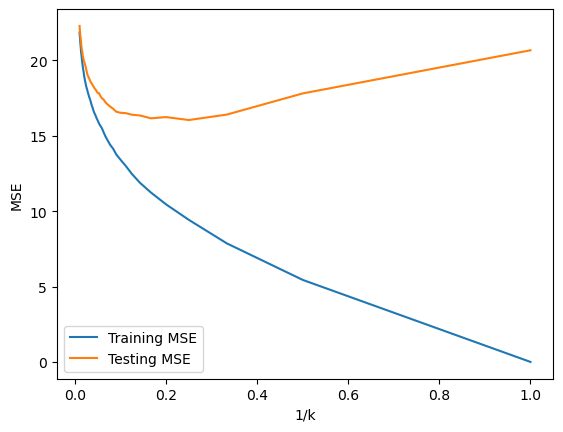

In [23]:
plot_graph(attributes["Reciprocal of k"], attributes["Train Error"], attributes["Test Error"])

In [24]:
# KNN using NORMALIZED features
[summary_normalized, attributes_normalized] = KNN_Regression("NORMALIZED_KNN")
display_result_normalized = {
    "Mode Type": summary_normalized["Mode Type"],
    "K": summary_normalized["k"],
    "Train Error": summary_normalized["Train Error"],
    "Test Error": summary_normalized["Test Error"]
}
pd.DataFrame(display_result_normalized.items())

NORMALIZED Mode Type Activated


,0,1
0,Mode Type,NORMALIZED_KNN
1,K,7.0
2,Train Error,10.8555
3,Test Error,15.3486


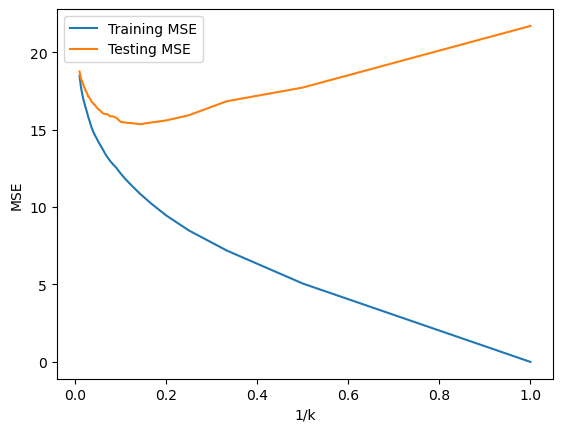

In [25]:
plot_graph(attributes_normalized["Reciprocal of k"], attributes_normalized["Train Error"], attributes_normalized["Test Error"])

### (j) Compare the results of KNN Regression with the linear regression model that has the smallest test error and provide your analysis.

In [26]:
display_all_results = {}
for key, value in attributes_normalized["Error Summary"].items():
    display_all_results[key] = [round(x, 4) for x in value]

display_all_results
pd.DataFrame(data=display_all_results.items(), columns=["Mode Type", "[Training Error, Testing Error]"])

,Mode Type,"[Training Error, Testing Error]"
0,all_predictors_linear_reg,"[20.5187, 21.3571]"
1,quadratic_terms_linear_reg,"[17.8713, 18.6776]"
2,discard_insignificant_predictors_linear_reg,"[17.9264, 18.6596]"
3,RAW_KNN,"[9.422, 16.0461]"
4,NORMALIZED_KNN,"[10.8555, 15.3486]"


> As displayed in the table above, we conclude that the KNN regression gives better performance based on the Mean Square Error values. The reason that KNN performs better than linear regression is that the data is difficult to separate linearly. That means the feature space of our dataset is possibly more complex than following a simple linear relationship, i.e, our data is non-linear in nature. 

### 2. ISLR: 2.4.1

For each of parts (a) through (d), indicate whether we would generally expect the performance of a flexible statistical learning method to be better or worse than an inflexible method. Justify your answer.

(a) The sample size n is extremely large, and the number of predictors p is small.

> Answer 

>> Large sample size along with small number of predictors can cause the model to underfit if the model is an inflexible statistical learning method. So, a more flexible approach will fit the data closer and with the
large sample size, a better fit than an inflexible approach would be obtained. Hence, a flexible model will perform better than an inflexible model.

(b) The number of predictors p is extremely large, and the number of observations n is small.

> Answer  

>> Small sample size along with large number of predictors will cause a flexible model to overfit. Hence, a flexible model will perform worse than an inflexible model.

(c) The relationship between the predictors and response is highly non-linear.

> Answer  

>> An inflexible model will not be able to adjust to the variances of a highly non-linear model. Hence, with more degrees of freedom, a flexible model would obtain a better fit than a non-flexible model in this situation.

(d) The variance of the error terms, i.e. σ2 = Var(ε), is extremely high.

> Answer  

>> High variance = More noise which means that a flexible model will overfit. Overfitting is a bad thing and hence, here, a flexible statistical model will perform worse as compared to an inflexible model.

### ISLR: 2.4.7

The table below provides a training data set containing six observations, three predictors, and one qualitative response variable.

(a) Compute the Euclidean distance between each observation and the test point, $X1 = X2 = X3 =0$.

| Obs             | $X_1$           |$X_2$|$X_3$|$Y$|
| -- | -- |-- |--|--|
| 1 | 0 | 3 | 0 | Red |
| 2 | 2 | 0 | 0 | Red |
| 3 | 0 | 1 | 3 | Red |
| 4 | 0 | 1 | 2 | Green |
| 5 | -1 | 0 | 1 | Green |
| 6 | 1 | 1 | 1 | Red |

> The euclidean distance between any 2 points in an n-dimensional space is -

>> $ d\left( p,q\right)   = \sqrt {\sum _{i=1}^{n}  \left( q_{i}-p_{i}\right)^2 } $

In [27]:
X_predictors = [[0,3,0], [2,0,0], [0,1,3], [0,1,2], [-1,0,1], [1,1,1]]
test = [[0,0,0]]
result = euclidean_distances(X_predictors, test)
pd.DataFrame(result, index=[1,2,3,4,5,6], columns=[f"Euclidean Distance between $Obs_i$ and test-point"])

,Euclidean Distance between $Obs_i$ and test-point
1,3.000000
2,2.000000
3,3.162278
4,2.236068
5,1.414214
6,1.732051


(b) What is our prediction with $𝐾=1$ ? Why?
>> For $K=1$, the predicted output would be the Observation # 5 since that is the nearest to the test point when k = 1. Therefore, the prediction of Y is green.

(c) What is our prediction with $K = 3$? Why?
>> For $K=3$, the predicted output would be the Observation #s 2 (Red), 5 (Green) and 6 (Red) as they are the closest neighbours when $K=3$. Since the majority poll is 1 Green vs 2 Red, the predicted output is going to be Red.

(d) If the Bayes decision boundary in this problem is highly non-linear, then would we expect the best value for K to be large or small? Why?
>> A small K would be flexible for a non-linear decision boundary, whereas a large K would try to fit a more linear boundary because it takes more points into consideration. Hence, a smaller value of K will works better when decision boundary is highly non-linear. 